# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will train your CNN-RNN model.  

You are welcome and encouraged to try out many different architectures and hyperparameters when searching for a good model.

This does have the potential to make the project quite messy!  Before submitting your project, make sure that you clean up:
- the code you write in this notebook.  The notebook should describe how to train a single CNN-RNN architecture, corresponding to your final choice of hyperparameters.  You should structure the notebook so that the reviewer can replicate your results by running the code in this notebook.  
- the output of the code cell in **Step 2**.  The output should show the output obtained when training the model from scratch.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Training Setup
- [Step 2](#step2): Train your Model
- [Step 3](#step3): (Optional) Validate your Model

<a id='step1'></a>
## Step 1: Training Setup

In this step of the notebook, you will customize the training of your CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values you set now will be used when training your model in **Step 2** below.

You should only amend blocks of code that are preceded by a `TODO` statement.  **Any code blocks that are not preceded by a `TODO` statement should not be modified**.

### Task #1

Begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend that you set `num_epochs=3`, but feel free to increase or decrease this number as you wish.  [This paper](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but you'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if you want your model to compete with current research, you will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend that you set `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that you **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  You are encouraged to keep this at its default value of `100` to avoid clogging the notebook, but feel free to change it.
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

If you're not sure where to begin to set some of the values above, you can peruse [this paper](https://arxiv.org/pdf/1502.03044.pdf) and [this paper](https://arxiv.org/pdf/1411.4555.pdf) for useful guidance!  **To avoid spending too long on this notebook**, you are encouraged to consult these suggested research papers to obtain a strong initial guess for which hyperparameters are likely to work best.  Then, train a single model, and proceed to the next notebook (**3_Inference.ipynb**).  If you are unhappy with your performance, you can return to this notebook to tweak the hyperparameters (and/or the architecture in **model.py**) and re-train your model.

### Question 1

**Question:** Describe your CNN-RNN architecture in detail.  With this architecture in mind, how did you select the values of the variables in Task 1?  If you consulted a research paper detailing a successful implementation of an image captioning model, please provide the reference.

**Answer:** 

I leave the encoder CNN as the default architecture, which is ResNet50 without further adjustment. ResNet has been proven to result in the best performance on [image recognition](https://arxiv.org/abs/1512.03385) while it is less complicated and easier to optimize. It is also widely used in image captions such as in this [demo](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/blob/master/models.py). There are different variations of ResNet architecture with differnt depth(ResNet34, 50, 101, 152). The deeper the network the more accurate the model performs. I choose **ResNet50** in order to lessen the computation strain and it already comes up with pretty good result in empirical tests.

---

For decoder RNN, I choose to have **single LSTM layer** as how it is configured in this paper - [Show and Tell: A Neural Image Caption Generator](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Vinyals_Show_and_Tell_2015_CVPR_paper.pdf). It's not necessary to have a stacked LSTM model for the prior research already shows image caption model tends to be over-fitting easily. But I don't include dropout layer in Decoder model, for I found out the performance is somehow even worse with dropout layer. Noted that I use `nn.LSTM` to build up the model. In the furst trial, I use `nn.LstmCell` to build up the model. I thought it would be easier to implement Beam Search caption generation latter, but [many advices](https://discuss.pytorch.org/t/different-between-lstm-and-lstmcell-function/5657/2) online warn better not to use `nn.LstmCell`. Especially, `nn.LstmCell` is not cuda optimized and I also notice that my model built on `nn.LstmCell` keeps giving the same predicted caption on different image. Possibly there contain some bugs in nn.LstmCell.  

---

For hyperparameters, I set up batch size to be 128. Larger batch size helps to increase training speed. I set up the vocab_threshold to be 6, and it would train the model focusing more on frequent words. Embed size and hidden size are set 512, following what is used in the *show and tell image caption* paper. Number of epoch is 2 so that I can save two epoch models and compare performance between them in validation phase. 


### (Optional) Task #2

Note that we have provided a recommended image transform `transform_train` for pre-processing the training images, but you are welcome (and encouraged!) to modify it as you wish.  When modifying this transform, keep in mind that:
- the images in the dataset have varying heights and widths, and 
- if using a pre-trained model, you must perform the corresponding appropriate normalization.

### Question 2

**Question:** How did you select the transform in `transform_train`?  If you left the transform at its provided value, why do you think that it is a good choice for your CNN architecture?

**Answer:** I leave the specification of `transform_train` unchanged. I think the transformations pretty cover the most important elements such as basic data augmentation on random crop and horinzontal flip and converting the image to required size and pixel values for use in pre-trained model.

### Task #3

Next, you will specify a Python list containing the learnable parameters of the model.  For instance, if you decide to make all weights in the decoder trainable, but only want to train the weights in the embedding layer of the encoder, then you should set `params` to something like:
```
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 
```

### Question 3

**Question:** How did you select the trainable parameters of your architecture?  Why do you think this is a good choice?

**Answer:** It is frequently adviced to leave the pre-trained model intact. These pre-trained model aleady have pretty good fine-tuned weights. Hence, I would prefer to train the weights on the final output of the CNN and the whole newly build model RNN to fit in current image caption task.

### Task #4

Finally, you will select an [optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Optimizer).

### Question 4

**Question:** How did you select the optimizer used to train your model?

**Answer:** I choose Adam optimizer. It's one of best recommended optimization algorithms. It also well fits in various training cases. I leave the arguments for Adam optimizer as default. In [this post](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) it explicitly mentions to set up beta 1 and beta 2 as (0.9, 0.999). The setting is most suitable for addressing cases in NLP and computer vision.

In [1]:
import nltk
nltk.download('punkt')
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 128           # batch size
vocab_threshold = 6        # minimum word count threshold
vocab_from_file = False    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 2             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 1000         # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

# Set the total number of training steps per epoch. -> to round down for getting full batch size
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
loading annotations into memory...
Done (t=1.05s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.92s)
creating index...


  0%|          | 1199/414113 [00:00<01:08, 5991.49it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:11<00:00, 5775.87it/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 27049277.85it/s]


<a id='step2'></a>
## Step 2: Train your Model

Once you have executed the code cell in **Step 1**, the training procedure below should run without issue.  

It is completely fine to leave the code cell below as-is without modifications to train your model.  However, if you would like to modify the code used to train the model below, you must ensure that your changes are easily parsed by your reviewer.  In other words, make sure to provide appropriate comments to describe how your code works!  

You may find it useful to load saved weights to resume training.  In that case, note the names of the files containing the encoder and decoder weights that you'd like to load (`encoder_file` and `decoder_file`).  Then you can load the weights by using the lines below:

```python
# Load pre-trained weights before resuming training.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
```

While trying out parameters, make sure to take extensive notes and record the settings that you used in your various training runs.  In particular, you don't want to encounter a situation where you've trained a model for several hours but can't remember what settings you used :).

### A Note on Tuning Hyperparameters

To figure out how well your model is doing, you can look at how the training loss and perplexity evolve during training - and for the purposes of this project, you are encouraged to amend the hyperparameters based on this information.  

However, this will not tell you if your model is overfitting to the training data, and, unfortunately, overfitting is a problem that is commonly encountered when training image captioning models.  

For this project, you need not worry about overfitting. **This project does not have strict requirements regarding the performance of your model**, and you just need to demonstrate that your model has learned **_something_** when you generate captions on the test data.  For now, we strongly encourage you to train your model for the suggested 3 epochs without worrying about performance; then, you should immediately transition to the next notebook in the sequence (**3_Inference.ipynb**) to see how your model performs on the test data.  If your model needs to be changed, you can come back to this notebook, amend hyperparameters (if necessary), and re-train the model.

That said, if you would like to go above and beyond in this project, you can read about some approaches to minimizing overfitting in section 4.3.1 of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).  In the next (optional) step of this notebook, we provide some guidance for assessing the performance on the validation dataset.

In [2]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time
from workspace_utils import active_session

In [3]:
# active_session to keep Udacity workspace awake
with active_session():
    # Open the training log file.
    f = open(log_file, 'w')

    old_time = time.time()
    response = requests.request("GET", 
                                "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                                headers={"Metadata-Flavor":"Google"})

    for epoch in range(1, num_epochs+1):

        for i_step in range(1, total_step+1):

            if time.time() - old_time > 60:
                old_time = time.time()
                requests.request("POST", 
                                 "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                                 headers={'Authorization': "STAR " + response.text})

            # Randomly sample a caption length, and sample indices with that length.
            indices = data_loader.dataset.get_train_indices()
            # Create and assign a batch sampler to retrieve a batch with the sampled indices.
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            data_loader.batch_sampler.sampler = new_sampler

            # Obtain the batch.
            images, captions = next(iter(data_loader))

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            captions = captions.to(device)

            # Zero the gradients.
            decoder.zero_grad()
            encoder.zero_grad()

            # Pass the inputs through the CNN-RNN model.
            features = encoder(images)
            outputs = decoder(features, captions)

            # Calculate the batch loss.
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

            # Backward pass.
            loss.backward()

            # Update the parameters in the optimizer.
            optimizer.step()

            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))

            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

            # Print training statistics to file.
            f.write(stats + '\n')
            f.flush()

            # Print training statistics (on different line).
            if i_step % print_every == 0:
                print('\r' + stats)

        # Save the weights.
        if epoch % save_every == 0:
            torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
            torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

    # Close the training log file.
    f.close()

Epoch [1/2], Step [1000/3236], Loss: 2.9181, Perplexity: 18.5066
Epoch [1/2], Step [2000/3236], Loss: 2.2678, Perplexity: 9.65836
Epoch [1/2], Step [3000/3236], Loss: 2.2601, Perplexity: 9.583607
Epoch [2/2], Step [1000/3236], Loss: 2.1077, Perplexity: 8.22939
Epoch [2/2], Step [2000/3236], Loss: 2.0001, Perplexity: 7.39013
Epoch [2/2], Step [3000/3236], Loss: 2.0688, Perplexity: 7.915249
Epoch [2/2], Step [3236/3236], Loss: 2.1812, Perplexity: 8.85715

<a id='step3'></a>
## Step 3: (Optional) Validate your Model

To assess potential overfitting, one approach is to assess performance on a validation set.  If you decide to do this **optional** task, you are required to first complete all of the steps in the next notebook in the sequence (**3_Inference.ipynb**); as part of that notebook, you will write and test code (specifically, the `sample` method in the `DecoderRNN` class) that uses your RNN decoder to generate captions.  That code will prove incredibly useful here. 

If you decide to validate your model, please do not edit the data loader in **data_loader.py**.  Instead, create a new file named **data_loader_val.py** containing the code for obtaining the data loader for the validation data.  You can access:
- the validation images at filepath `'/opt/cocoapi/images/val2014/'`, and
- the validation image caption annotation file at filepath `'/opt/cocoapi/annotations/captions_val2014.json'`.

The suggested approach to validating your model involves creating a json file such as [this one](https://github.com/cocodataset/cocoapi/blob/master/results/captions_val2014_fakecap_results.json) containing your model's predicted captions for the validation images.  Then, you can write your own script or use one that you [find online](https://github.com/tylin/coco-caption) to calculate the BLEU score of your model.  You can read more about the BLEU score, along with other evaluation metrics (such as TEOR and Cider) in section 4.1 of [this paper](https://arxiv.org/pdf/1411.4555.pdf).  For more information about how to use the annotation file, check out the [website](http://cocodataset.org/#download) for the COCO dataset.

In [1]:
# (Optional) TODO: Validate your model.
!pip install nltk
import nltk
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from tqdm import tqdm
import torch
import torch.utils.data as data
from torchvision import transforms
from model import EncoderCNN, DecoderRNN
from data_loader_val import val_get_loader
import os

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# instantiate val_get_loader
val_transform = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                         std=(0.229, 0.224, 0.225))])

val_data_loader = val_get_loader(transform=val_transform,
                                 mode='validation',
                                 batch_size=1,
                                 vocab_file='./vocab.pkl',
                                 vocab_from_file=True,
                                 cocoapi_loc='/opt')

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.49s)
creating index...


  1%|          | 1075/202654 [00:00<00:39, 5134.10it/s]

index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:34<00:00, 5860.64it/s]


In [3]:
def clean_sentence(output):
    word_list = []
    for idx in output:
        word_list.append(val_data_loader.dataset.vocab.idx2word[idx])
    word_list = word_list[1:-1] # Discard <start> and <end> words
    sentence = ' '.join(word_list)
    sentence = sentence.capitalize()
    return sentence

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(val_data_loader.dataset.vocab)

In [5]:
# load in model of epoch 1
encoder_file1 = 'encoder-{}.pkl'.format(1)
decoder_file1 = 'decoder-{}.pkl'.format(1)

encoder1 = EncoderCNN(embed_size=512)
encoder1.eval()
decoder1 = DecoderRNN(embed_size=512, hidden_size=512, vocab_size=vocab_size)
decoder1.eval()

encoder1.load_state_dict(torch.load(os.path.join('./models', encoder_file1)))
decoder1.load_state_dict(torch.load(os.path.join('./models', decoder_file1)))

encoder1.to(device)
decoder1.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 50511603.08it/s]


DecoderRNN(
  (embed): Embedding(8099, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=8099, bias=True)
)

In [6]:
# load in model of epoch 2
encoder_file2 = 'encoder-{}.pkl'.format(2)
decoder_file2 = 'decoder-{}.pkl'.format(2)

encoder2 = EncoderCNN(embed_size=512)
encoder2.eval()
decoder2 = DecoderRNN(embed_size=512, hidden_size=512, vocab_size=vocab_size)
decoder2.eval()

encoder2.load_state_dict(torch.load(os.path.join('./models', encoder_file2)))
decoder2.load_state_dict(torch.load(os.path.join('./models', decoder_file2)))

encoder2.to(device)
decoder2.to(device)

DecoderRNN(
  (embed): Embedding(8099, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=8099, bias=True)
)

In [7]:
max_images = 200 # number of images for validation
greedy_score1_list = []
beam_score1_list = []
greedy_score2_list = []
beam_score2_list = []
cnt = 0
for _ in range(max_images):

    indices = val_data_loader.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
    val_data_loader.batch_sampler.sampler = new_sampler

    img, caption = next(iter(val_data_loader)) # batch size 1
    img = img.to(device)
    features1 = encoder1(img).unsqueeze(1)
    output1 = decoder1.sample(features1)
    output1 = nltk.tokenize.word_tokenize(clean_sentence(output1))
    caption = nltk.tokenize.word_tokenize(clean_sentence(caption.tolist()[0]))
    score1 = sentence_bleu(caption, output1)
    greedy_score1_list.append(score1)
    
    beam1 = decoder1.beam_search(features1)
    beam1 = nltk.tokenize.word_tokenize(clean_sentence(beam1))
    beam_score1 = sentence_bleu(caption, beam1)
    beam_score1_list.append(beam_score1)

    features2 = encoder2(img).unsqueeze(1)
    output2 = decoder2.sample(features2)
    output2 = nltk.tokenize.word_tokenize(clean_sentence(output2))
    score2 = sentence_bleu(caption, output2)
    greedy_score2_list.append(score2)
    
    
    beam2 = decoder2.beam_search(features2)
    beam2 = nltk.tokenize.word_tokenize(clean_sentence(beam2))
    beam_score2 = sentence_bleu(caption, beam2)
    beam_score2_list.append(beam_score2)
    
    cnt += 1

print('model-1 average greedy score:{:8.5f}'.format(sum(greedy_score1_list)/cnt))
print('model-1 average beam score:{:8.5f}'.format(sum(beam_score1_list)/cnt))
print('model-2 average greedy score:{:8.5f}'.format(sum(greedy_score2_list)/cnt))
print('model-2 average beam score:{:8.5f}'.format(sum(beam_score2_list)/cnt))

/opt/conda/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


model-1 average greedy score: 0.68408
model-1 average beam score: 0.66915
model-2 average greedy score: 0.67387
model-2 average beam score: 0.66986


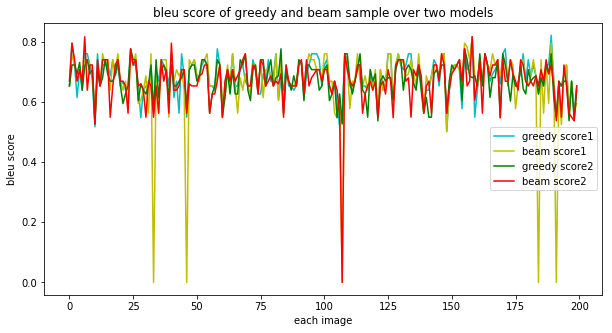

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(max_images), np.array(greedy_score1_list), '-c', label='greedy score1')
plt.plot(np.arange(max_images), np.array(beam_score1_list), '-y', label='beam score1')
plt.plot(np.arange(max_images), np.array(greedy_score2_list), '-g', label='greedy score2')
plt.plot(np.arange(max_images), np.array(beam_score2_list), '-r', label='beam score2')
plt.title('bleu score of greedy and beam sample over two models')
plt.ylabel('bleu score')
plt.xlabel('each image')
plt.legend()
plt.show()